In [1]:
# Use all exogenous variables in a SARIMAX model to predict the real GDP
# Produce forecasts for the last seven timesteps in the dataset.
# Measure the MAPE. Is it better, worse, or identical to what was achieved with a limited number of exogenous variables?

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

In [3]:
# Macroeconomics dataset from the United States, collected quarterly from 1959 to 2009, to forecast the real GDP
# This dataset is available with the statsmodels library

import statsmodels.api as sm

econ_data = sm.datasets.macrodata.load_pandas().data
econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [4]:
econ_data.describe()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,1983.876847,2.492611,7221.171901,4825.293103,1012.863862,663.328640,5310.540887,105.075788,667.927586,5.311773,5.884729,239.724153,3.961330,1.336502
std,14.686817,1.118563,3214.956044,2313.346192,585.102267,140.863655,2423.515977,61.278878,455.346381,2.803071,1.458574,37.390450,3.253216,2.668799
min,1959.000000,1.000000,2710.349000,1707.400000,259.764000,460.400000,1886.900000,28.980000,139.600000,0.120000,3.400000,177.146000,-8.790000,-6.790000
25%,1971.000000,1.500000,4440.103500,2874.100000,519.147500,527.959500,3276.950000,41.050000,228.650000,3.515000,4.900000,208.631000,2.270000,-0.085000
50%,1984.000000,2.000000,6559.594000,4299.900000,896.210000,662.412000,4959.400000,104.100000,540.900000,5.010000,5.700000,236.348000,3.240000,1.340000
75%,1996.500000,3.000000,9629.346500,6398.150000,1436.681500,773.049000,6977.850000,159.650000,1102.100000,6.665000,6.800000,271.721500,4.975000,2.630000
max,2009.000000,4.000000,13415.266000,9363.600000,2264.721000,1044.088000,10077.500000,218.610000,1673.900000,15.330000,10.700000,308.013000,14.620000,10.950000


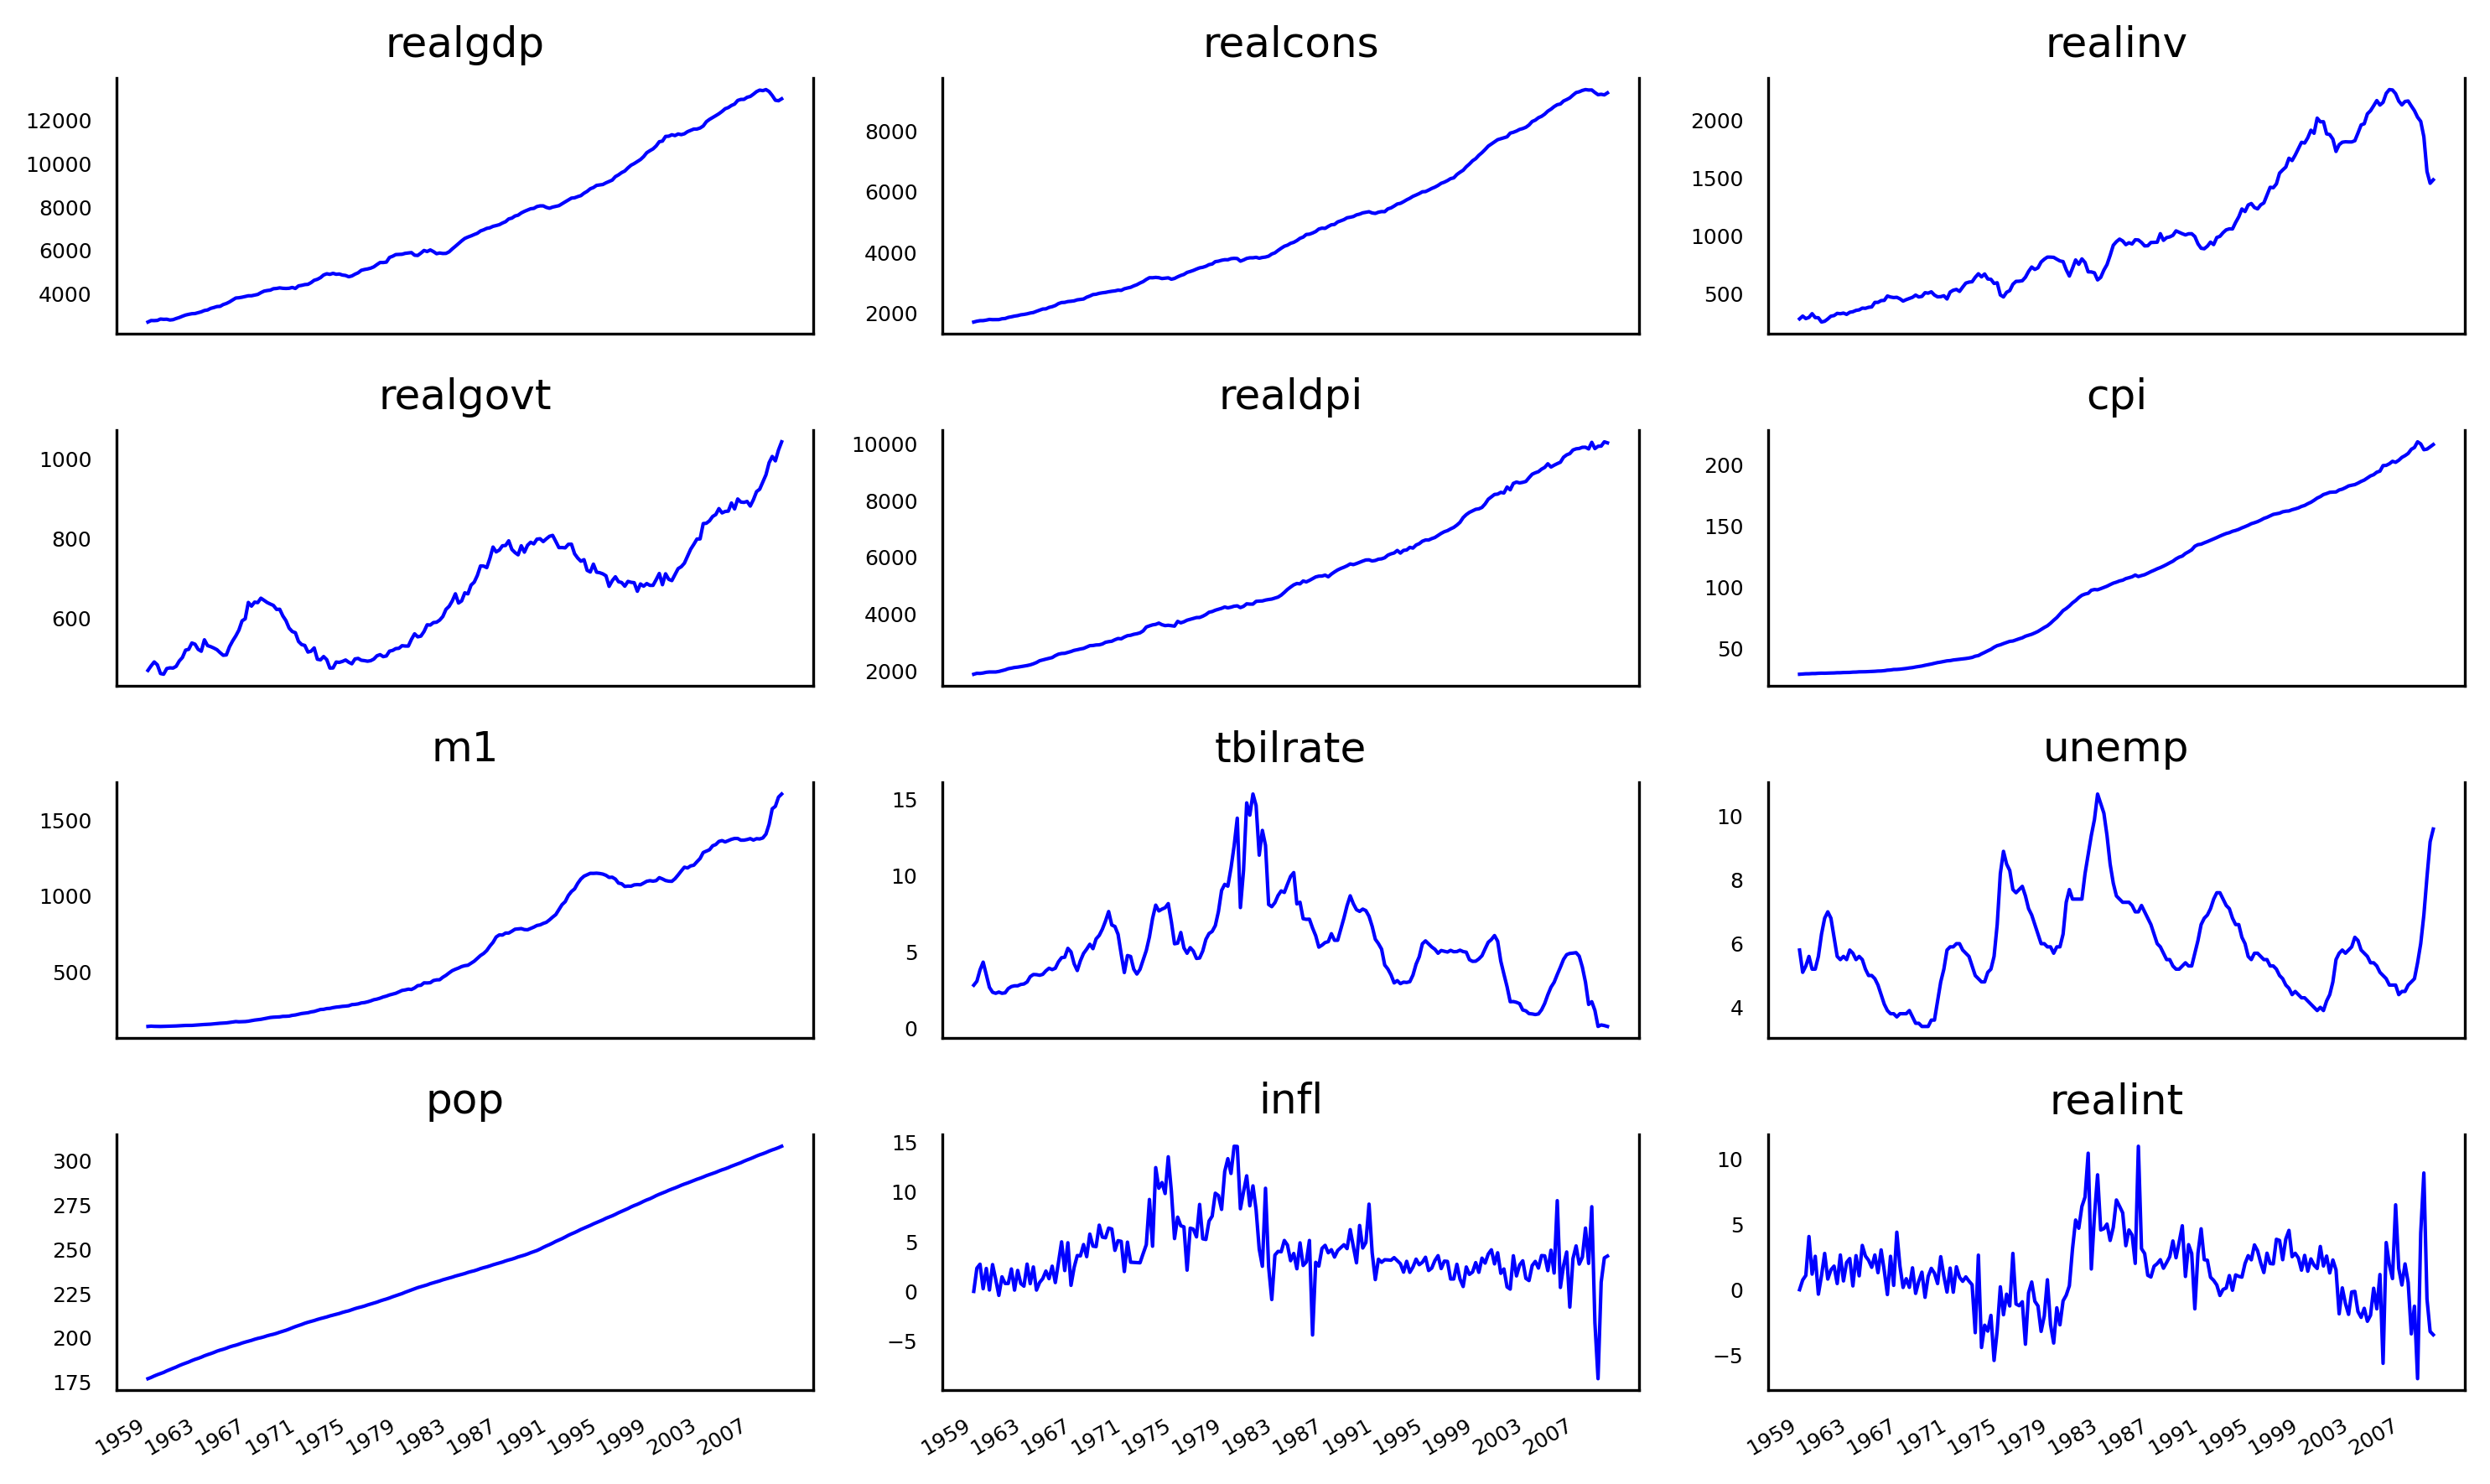

In [5]:
# Apart from the coulmns for year and quarter, all the rest are used

fig, axes = plt.subplots(nrows=4, ncols=3, dpi=300, figsize=(10,6))

# Iterate for twelve variables
for i, ax in enumerate(axes.flatten()[:12]):
    #Skip the year and quarter columns, so that we start at realgdp
    data = econ_data[econ_data.columns[i+2]]
    
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 16), xticklabels=np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [6]:
# Whereas graphical analysis is NOT sufficient to draw conclusions, realcons, realdpi, cpi, pop and 
# to a smaller extent m1 seem to be good predictors of realgdp

In [7]:
# Define the target variable i.e. realgdp
target = econ_data['realgdp']

# Define the exogenous variables
exog = econ_data[['realcons','realinv','realgovt','realdpi','cpi','m1','tbilrate','unemp','pop','infl','realint']]

adf_result = adfuller(target)

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: 1.7504627967647088
p-value: 0.9982455372335032


In [8]:
# The process is not statitionery -> ADF statistic is not a large negative number and p-value is greater than 0.05..
# So we apply differentiation to make it stationery

target_diff = np.diff(target, n=1)

adf_result = adfuller(target_diff)

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08


In [9]:
# With a large negative ADF statistic and a p-value smaller than 0.05, we can conclude that the series is now stationary.
d = 1

In [10]:
# Function to fit all unique SARIMAX models

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []

    # Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar
    for order in tqdm(order_list):
        try:
            # Fit an SARIMAX(p,d,q)(P, D, Q)m model using the SARIMAX function.
            # We specify simple_differencing=False, to prevent differencing.
            # We also specify disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, 
                            exog,
                            order=(order[0], d, order[1]), 
                            seasonal_order = (order[2], D, order[3], s),
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
# Define the range of possible values for the orders p, q, P, and Q

from itertools import product

p = range(0, 4, 1)
q = range(0, 4, 1)

P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)

# The parameter s is equivalent to m. They both denote the frequency.
s = 4

order_list = list(product(p, q, P, Q))

In [12]:
# To train the model, we will use the first 200 instances of both the target and exogenous variables
import warnings
warnings.filterwarnings('ignore')

target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, order_list, d, D, s)
result_df

,"(p,q,P,Q)",AIC
0,"(2, 2, 1, 0)",1757.106537
1,"(3, 3, 0, 0)",1757.886618
2,"(2, 2, 0, 2)",1758.325120
3,"(2, 2, 0, 0)",1759.095423
4,"(2, 2, 2, 0)",1759.449635
...,...,...
251,"(3, 2, 2, 1)",1776.806717
252,"(3, 2, 1, 3)",1776.867118
253,"(3, 2, 1, 1)",1776.944882
254,"(3, 2, 1, 2)",1778.131947


In [13]:
# The verdict is that the SARIMAX(2,1,2)(1,0,0)4 model is the model with the lowest AIC - Akaike Information Criterion

In [14]:
# Now fit the selected model and display a summary table to see the coefficients associated with our exogenous variables

best_model = SARIMAX(target_train, exog_train, order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

residuals = best_model_fit.resid

print(best_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -861.553
Date:                            Tue, 10 Oct 2023   AIC                           1757.107
Time:                                    13:33:43   BIC                           1813.093
Sample:                                         0   HQIC                          1779.766
                                            - 200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9568      0.053     17.971      0.000       0.852       1.061
realinv        1.0018      0.042   

In [15]:
# Notice that most of the variables have a p-value larger than 0.05 e.g. realdpi, m1,tbilrate, unemp, pop, infl, real, int
# This means that their coefficient are not significantly different from 0.
# However p=value does NOT determine relavance in forcasting the target, so we retain them in the model

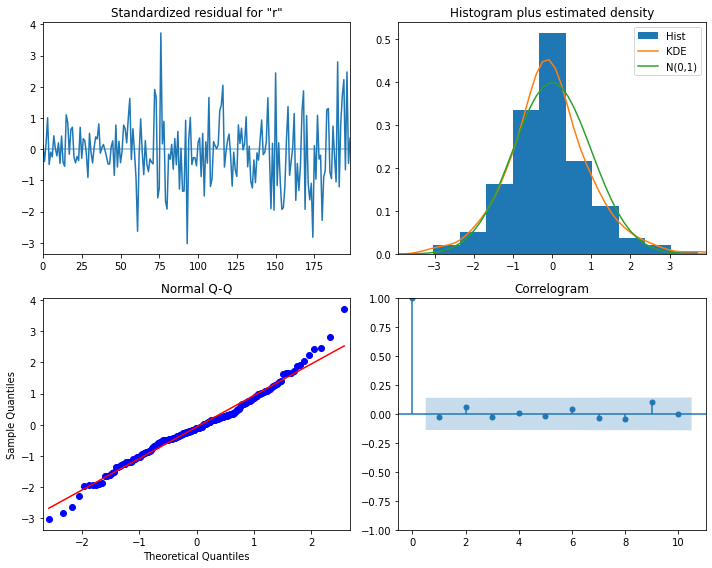

In [16]:
best_model_fit.plot_diagnostics(figsize=(10,8))

plt.tight_layout()

In [17]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see what is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficients after lag 0, just like white noise.

# Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, 
# as it means that the model’s errors are random.

In [18]:
# Next run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated

from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue = acorr_ljungbox(residuals, np.arange(1,11,1), return_df=True)
lbvalue.columns = ['stat', 'p-value']
lbvalue

,stat,p-value
1,0.014589,0.903862
2,0.061224,0.969852
3,0.076929,0.994454
4,0.213206,0.994706
5,0.222863,0.998848
6,0.226124,0.999779
7,0.226390,0.999962
8,0.293810,0.999983
9,0.308490,0.999996
10,0.309294,0.999999


In [19]:
# All the p-values are greater than 0.05. Therefore, we conclude that the residuals are independent and uncorrelated

# Having passed both residual checks, our model can be used for forecasting
# Model test: use rolling forecast to predict the next timestep multiple times & average the errors of each prediction
# last known value method is used as a baseline

In [20]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, 
                     window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value
    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)

            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [21]:
# We fit the model on the data from 1959 to the end of 2007
target_train = target[:196].copy()

# The test set contains the values starting in 2008 to the third quarter of 2009. 
# There is a total of seven values to predict
target_test = target[196:].copy()

pred_df = pd.DataFrame({'actual': target_test})

In [22]:
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)

# we predict the next timestep only
WINDOW = 1

print(TRAIN_LEN)
print(HORIZON)

196
7


In [23]:
pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['last_value'] = pred_last_value
pred_df['SARIMAX'] = pred_SARIMAX

pred_df

,actual,last_value,SARIMAX
196,13366.865,13391.249,13340.310221
197,13415.266,13366.865,13374.279300
198,13324.600,13415.266,13372.127340
199,13141.920,13324.600,13329.885727
200,12925.410,13141.920,13136.803833
201,12901.504,12925.410,12888.091489
202,12990.341,12901.504,12869.157069


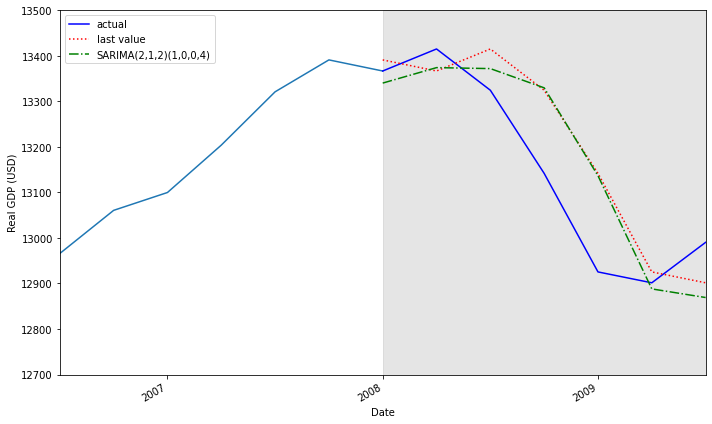

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(econ_data['realgdp'][:197])
ax.plot(pred_df['actual'], 'b-', label='actual')
ax.plot(pred_df['last_value'], 'r:', label='last value')
ax.plot(pred_df['SARIMAX'], 'g-.', label = 'SARIMA(2,1,2)(1,0,0,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (USD)')
ax.axvspan(196, 202, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 202, 4), np.arange(1959, 2010, 1))
ax.set_xlim(190, 202)
ax.set_ylim(12700, 13500)

fig.autofmt_xdate()
plt.tight_layout()

In [25]:
# function to compute the MAPE - Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
mape_last = mape(pred_df.actual, pred_df.last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.SARIMAX)

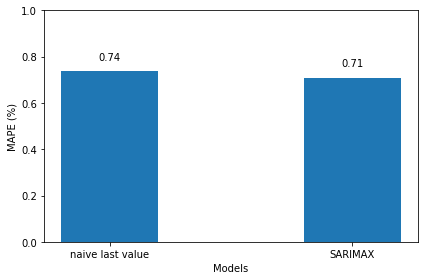

In [27]:
# Visualize which model has the lowest mean absolute percentage error (MAPE).

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

# Display the MAPE as text in the bar plot
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
plt.tight_layout()

In [28]:
# SARIMAX model is the winning model by only 0.03%. This difference represents thousands of dollars
# A SARIMAX model with all exogenous varibales performs slightly worse than what was achieved with a limited number 
# of exogenous variables 
# With only realcons, realinv, realgovt, realdpi, cpi, a MAPE of 0.70% was achieved

In [29]:
# Record end time

end = dt.now()
elapsed = end - start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:27:05
